## Group: Stanley


### Authors:
- Ana Alum Urbina 100475297 
- Alejo González García 100454351
- Alonso Madroñal de Mesa 100454449
- Andrés Navarro Pedregal 100451730
- Irina Vela Gómez 100454302

In [2]:
from IPython import display
from IPython.core.display import Image

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Degree in Data Science and Engineering, group 96, Stanley
## Machine Learning 2
### Fall 2023

&nbsp;
&nbsp;
&nbsp;
# Lab 2. Support Vector Machines for Classification

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Loading the dataset

In this assignment you will work with an adaptation of the UCI repository dataset [segmentation]('https://archive.ics.uci.edu/ml/datasets/image+segmentation'). It is a binary classification task (labels are $+1$ and $-1$, respectively).

The following cell loads the data and constructs the corresponding training and testing sets.

In [5]:
train_data = np.loadtxt('segmentation.data', delimiter=',')
X_train = train_data[:,1:]
y_train = train_data[:,0]
test_data = np.loadtxt('segmentation.test', delimiter=',')
X_test = test_data[:,1:]
y_test = test_data[:,0]

# 1.- Linear SVC

The first method we are going to use to solve the problem is a SVM endowed with a **linear kernel**. The performance of this model depends on the value of the regularization hyperparameter $C$.

## 1.1- Validation the hard way

In order to find which is the best value of $C$ in order to achieve the best generalization (a great performance on the test set without using the test set we are implementing the following **validation the hard way** procedure:

- Split **the training dataset** in two subsets:
    - actual training subset (70% of the data): `Xr` (observations) and `Yr` (targets)
    - validation subset (30% of the data): `Xv` and `Yv`

- Define `v_C` as a list with the following values for the parameter $C$: $10^{-3},$ $10^{-2},$ $10^{-1},$ $1,$ $10,$ $10^3,$ and $10^4$

 - Define `validation_accuracy` as an empty array with size equal to the length of `v_C`.
 
 - Run a loop with one iteration per member of `v_C`. At each iteration perform the following operations:
     - Instantiate a SVC with linear kernel and the value of $C$ corresponding to this iteration
     - Train the SVC with `Xr` and `Yr`
     - Evaluate the SVC with `Xv` and `Yv` and store the accuracy in the corresponding position of `validation_accuracy`
     
     
 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
Xr, Xv, Yr, Yv = train_test_split(X_train,y_train,
                                    test_size=0.3,
                                    random_state=42) #seed 

v_C = [1e-3, 1e-2, 1e-1, 1, 10, 1e+3, 1e+4]
print(v_C)

#validation_accuracy = [0.0] * len(v_C)
validation_accuracy = np.zeros(len(v_C))

for i in range(len(v_C)):
    svc = SVC(kernel='linear', C=v_C[i]).fit(Xr, Yr)
    validation_accuracy[i] = svc.score(Xv, Yv)

[0.001, 0.01, 0.1, 1, 10, 1000.0, 10000.0]


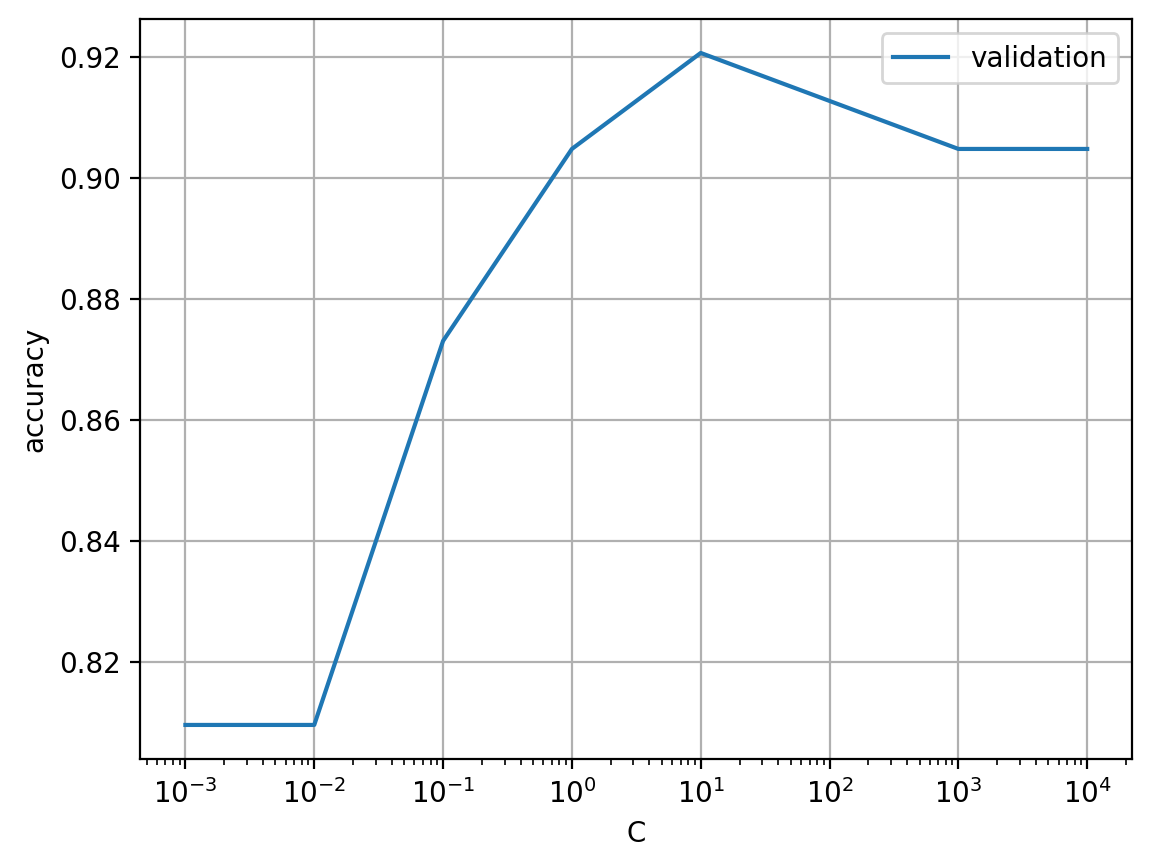

In [7]:
# do not edit this cell, just run it
plt.plot(np.array(v_C), validation_accuracy, label='validation')
plt.ylabel('accuracy')
plt.xlabel('C')
plt.grid()
plt.xscale('log')
_=plt.legend()

#### Discussion

- What is the value of $C$ that yields the better performance?

- What is the difference between the best value and the second best?

- Do you think it worths exploring larger or smaller values for $C$ (I mean, enlarging the explored range)?

#### your answer
1. The best value of C after checking our results is C = 10, with an accuracy of 92%

2. The next value is C = 1, with accuracy 90.5%

3. The higher the parameter C is, the higher the exploration you do, and more error you allow, so if you want to really see good values, the C must be large, but taking into account the cost. 
Looking at the smaller values we do not find it interesting to explore them further, maybe there are some larger values that are useful, but generally an accuracy of 92% is good enough.

Now we are going to check if the validation found the best parameter for the test set. In the next cell implement the following code:

- Define `test_accuracy` as an empty array with size equal to the length of `v_C`.
 
 - Run a loop with one iteration per member of `v_C`. At each iteration perform the following operations:
     - Instantiate a SVC with linear kernel and the value of $C$ corresponding to this iteration
     - Train the SVC with `X_train` and `y_train`
     - Evaluate the SVC with `X_test` and `y_test` and store the accuracy in the corresponding position of `test_accuracy`

In [8]:
test_accuracy = np.zeros(len(v_C))

for i in range(len(v_C)):
    svc = SVC(kernel='linear', C=v_C[i]).fit(X_train, y_train)
    test_accuracy[i] = svc.score(X_test, y_test)

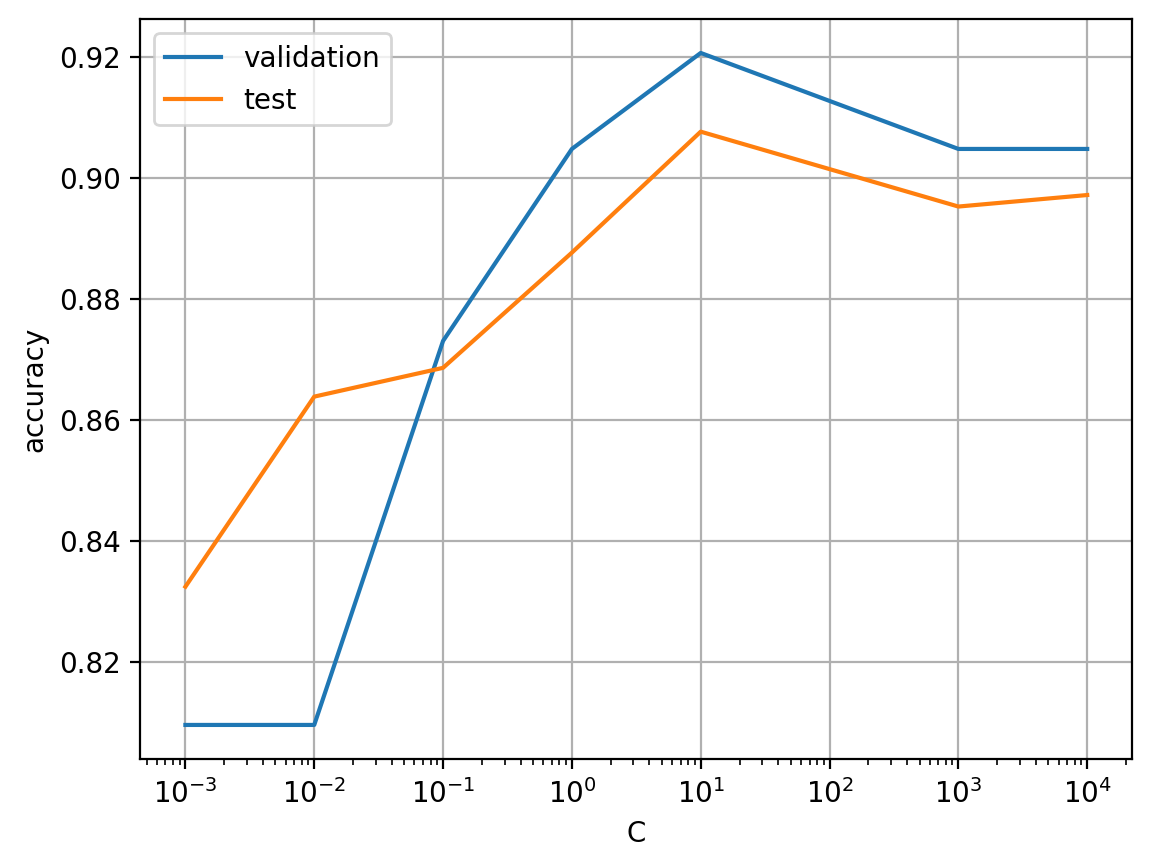

In [9]:
# do not edit this cell, just run it
plt.plot(np.array(v_C), validation_accuracy, label='validation')
plt.plot(np.array(v_C), test_accuracy, label='test')
plt.ylabel('accuracy')
plt.xlabel('C')
plt.grid()
plt.xscale('log')
_=plt.legend()

#### Discussion

- What is the value of $C$ that would yield the better performance in the test set?

- What is the difference between the best accuracy found for the test set and the accuracy that you will obtain if you use the value of $C$ found with validation?

- Do you think it worths exploring larger or smaller values for $C$ (I mean, enlarging the explored range)?

#### your answer
1. The value of C keeps been the same as before, but now the test corroborates it. for c = 10, we get 92% accuracy. Test accuracy is 0.905

2. The difference between training and testing is less than 1% so we are doing quite well as in the test we expect acc to be reduced. 

3. We do not think is longer worth it as the accuracy we are getting is quite good and enlarging the value of C has a much larger computational cost. If the resources were available and it was of great interest maybe it would be worth it but the accuracy we've gotten works perfectly

## 1.2.- GridSearchCV

The next step is to use crossvalidation to do the hyperparameter search in a more systematic and clean way.

### Grids of hyperparameters

This method consists in to form a **grid** with a number of dimensions equal to the number of hyperparameters that one needs to optimize. The size of each dimension of the grid is equal to the number of values in the range of the corresponding hyperparameter. Notice that this method explores **discrete** ranges for each hyperparameter.

For the SVC with linear kernel we will initially explore the following range:


- `C` $ \in$ $[10^{-3},$ $10^{-2},$ $10^{-1},$ $1,$ $10,$ $10^3,$  $10^4]$

Notice this range determine a $7 \times 1$ grid. 

In models that depend on a larger number of hyperparameters one has to be careful with the granularity of the ranges as the combinatorial explosion of the size of the grid can be hard to manage.

### Cross validation 

Cross validation is a commonly used procedure in machine learning to simulate the effect of training a model with a set of data and evaluate its generalization capabilities as the performance in a **separate dataset**. 

The cross validation process involves the following steps:

- Randomly partition the training dataset in $N$ disjoint subsets of similar sizes. Each of this subsets is called **fold** in machine learning jargon. Hence the term **N-fold cross validation**.

- Let us suppose we have chosen $N=3$ folds. This means the training data has been split in three subsets: $(X_1, Y_1)$, $(X_2, Y_2)$ y $(X_3, Y_3)$. 

- Create an instance of the model with the corresponding hyperparameters. The cross validation follows with the execution of the following loop

    For $n=1,2,\dots,N$ iterations:  
    1. Choose $(X_n,Y_n)$ as **validation set** for iteration $n$
    2. Prepare a **training set** for iteration $n$ joining the rest of the subsets (excluding the validation set)
    3. Fit the model instance with the training set of step 2
    4. Evaluate  the model instance (method `score`) with the validation set of step 1
    5. Keep the *score* achieved in the $n$ iteration.

- Once the loop is finished, we have $N$ scores, each corresponding to the evaluation of the model fitted in each iteration with the corresponding validation set.
- Estimate the **real score** that an instance of the model fitted using all the data would yield in a separate dataset computing the **mean** and **standard deviation** of the $N$ validation scores.

Typical values for the number of folds include $N\in \{3, 5, 10\}$


###  Cross validation to explore the grid

The grid is explored by a loop that visits all its nodes and runs a  **cross validation** to estimate the test performance that the model would yield if it were fitted using the values for hyperparameter that correspond to that node. 

Once all the nodes of the grid have been cross validated, the procedure outputs the combination of hyperparameters corresponding to the node with the best cross validation performance. 

###  Grid search in sklearn

There is a module in sklearn that implements this algorithm for exploring a grid of hyperparameters with cross validation: [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)


In the following cell implement code that:
- define `param_lsvc`, a dictionary that will serve as dictionary of parameters for the range of $C$
- instantiate `grid_lsvc`, an `GridSearchCV` object with a SVC with linear kernel as estimator and `param_lsvc` as parameter dictionary.
- Train `grid_lsvc` with `X_train` and `y_train`

In [10]:
from sklearn.model_selection import GridSearchCV

param_lsvc = {"C": v_C, "kernel": ["linear"]} # C must be capital letter and the kernels must be hold in a list

grid_lsvc = GridSearchCV(estimator = SVC(), param_grid = param_lsvc, cv = 5)
grid_lsvc.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 1000.0, 10000.0],
                         'kernel': ['linear']})

Now look at attribute `grid_lsvc.cv_results_` to identify fields that store:
- the values of parameter $C$ used in each node of the grid. Store them in an array called `values_of_C`
- the average score achieved by the model in each node of the grid. Store them in an array called `Mean_acc`
- the standard deviation of the scores achieved by the model in each node of the grid. Store them in an array called `Std_acc`

In [11]:
Mean_acc = grid_lsvc.cv_results_["mean_test_score"]; print(Mean_acc)
Std_acc = grid_lsvc.cv_results_["std_test_score"]; print(Std_acc)

# values_of_C = v_C; print(values_of_C)
values_of_C = list(grid_lsvc.cv_results_["param_C"].data); print(values_of_C)

#grid_lsvc.cv_results_


[0.80952381 0.76190476 0.81428571 0.84761905 0.86190476 0.86190476
 0.85714286]
[0.12325885 0.06208764 0.05714286 0.05553288 0.04856209 0.04856209
 0.05429407]
[0.001, 0.01, 0.1, 1, 10, 1000.0, 10000.0]


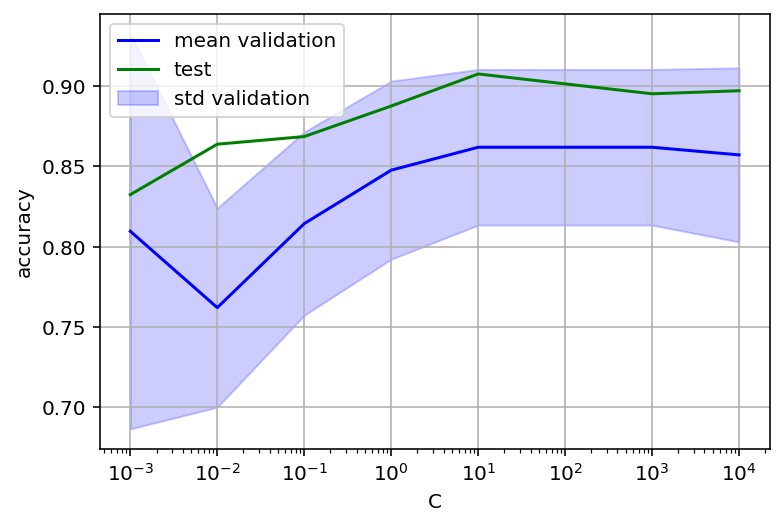

In [12]:
# do not edit this cell, just run it
plt.plot(values_of_C, Mean_acc, label='mean validation', color='blue')
plt.fill_between(values_of_C, 
                 Mean_acc - Std_acc, 
                 Mean_acc + Std_acc,
                 label='std validation',
                 alpha=0.2, 
                 color='blue')
plt.plot(values_of_C, test_accuracy, label='test', color='green')
plt.ylabel('accuracy')
plt.xlabel('C')
plt.grid()
plt.xscale('log')
_=plt.legend()

#### Discussion

- What is the value of $C$ that suggest GridSearchCV?

- What is the difference between the best accuracy found for the test set and the accuracy that you will obtain if you use the value of $C$ found by GridSearchCV?

- Is there any significant difference between GridSearchCV and validation the hard way?

#### your answer

1. GridSearchCV is suggesting C = 10 as before. We can see that the test peaks with that value and the average grows, so it is a good choice.

2. Now the difference is a bit higher than before, it´s around 5% less acc. 

3. GridSearchCV gives us a lot more of information and averages its accuracy with a lot more of training iterations and sampling, making it more reliable. 
We get the same value for C but now the accuracy is decremented as we have used cross validation with more samples and statistically our new results are more grounded and for this case, mean accuracy is lower. 

## 1.3.- Running times

GridSearchCV also provides with information about the times needed to train and to evaluate the algorithm. Identify what are the fields that provide with that information inside `grid_lsvc.cv_results_` and produce two plots, similar to the previous one in which you show:
- plot 1: The time (in seconds) employed to train the model vs. the value of $C$
- plot 2: The time (in seconds) employed to evaluate the model vs. the value of $C$

In [13]:
time_fit = grid_lsvc.cv_results_["mean_fit_time"]

time_score = grid_lsvc.cv_results_["mean_score_time"]

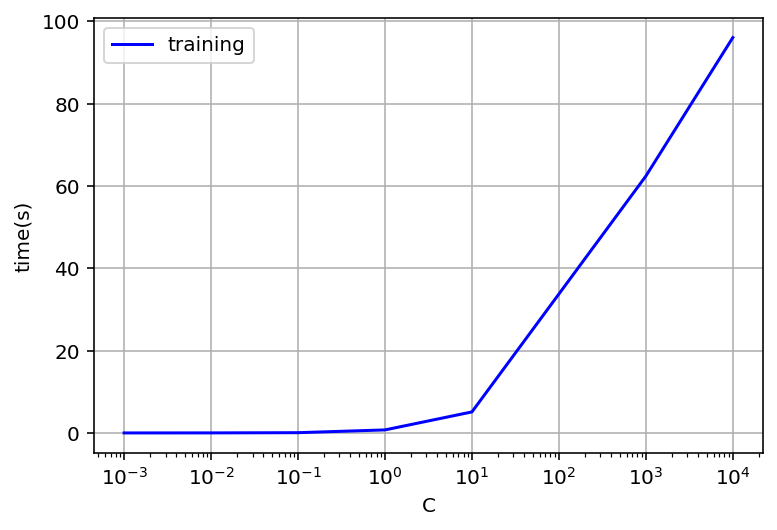

In [14]:
plt.plot(values_of_C, time_fit, label='training', color='blue')
#plt.plot(values_of_C, time_score, label='evaluation', color='green')
plt.ylabel('time(s)')
plt.xlabel('C')
plt.grid()
plt.xscale('log')
_=plt.legend()


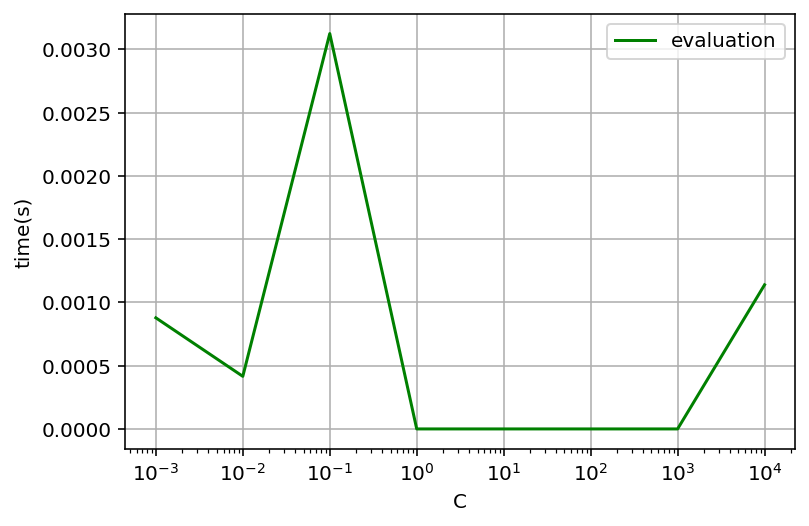

In [15]:
#plt.plot(values_of_C, time_fit, label='training', color='blue')
plt.plot(values_of_C, time_score, label='evaluation', color='green')
plt.ylabel('time(s)')
plt.xlabel('C')
plt.grid()
plt.xscale('log')
_=plt.legend()

#### Discussion

- How is the evolution of the training time with $C$?

- How is the evolution of the evaluation time with $C$?

#### your answer

1. We can see that the larger is C, the more computational time it takes 

2. For the evaluation, the time taken is really low and the difference does not depend on the value of C at all

# 2.- Explore different kernels

After obtaining results with the linear kernel, we will explore the performance of the SVM endowed with RBF and polynomial kernels.

## 2.1.- RBF kernel

The RBF kernel introduces a new hyperparameter in the model, the spread of the kernel $\gamma$. We will consider the following range of values: 
$$
\gamma \in [10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10]
$$

Therefore our crossvalidation grid search needs to expand one more dimension to allocate this range. 

In the next cell implement code that:
- Defines `v_g`, an array with the range of values for `gamma`
- Defines `param_rbf_svc`, a dictionary with the ranges of $\gamma$ and $C$ for the SVM
- Creates `grid_rbf_svc`, a `GridSearchCV` object with an SVC as estimator and  `param_rbf_svc` as parameter dictionary
- Train `grid_rbf_svc` with `X_train` and `y_train`

In [16]:
from sklearn.model_selection import GridSearchCV

v_g = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]; print(v_g)

param_rbf_svc = {"C": v_C, "gamma": v_g,}

model_rbf = SVC(kernel = "rbf")

grid_rbf_svc = GridSearchCV(estimator= model_rbf, param_grid=param_rbf_svc, cv=5, refit=True)
grid_rbf_svc.fit(X_train, y_train)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 1000.0, 10000.0],
                         'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]})

Now we need to retrieve useful information from attribute `cv_results_`, in particular:
- store in `C_values` the values of parameter $C$ used in each node of the grid
- store in `gamma_values` the values of parameter $\gamma$ used in each node of the grid
- store in `Acc` the average validation score obtained in each node of the grid


In [17]:
C_values = grid_rbf_svc.cv_results_["param_C"].data ; print(C_values)
gamma_values = grid_rbf_svc.cv_results_["param_gamma"].data; print(gamma_values)

Acc =  grid_rbf_svc.cv_results_["mean_test_score"]; print(Acc)

grid_rbf_svc.cv_results_

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.1 0.1 0.1 0.1 0.1 0.1 0.1 1 1 1 1 1 1 1 10 10 10 10 10 10 10
 1000.0 1000.0 1000.0 1000.0 1000.0 1000.0 1000.0 10000.0 10000.0 10000.0
 10000.0 10000.0 10000.0 10000.0]
[1e-05 0.0001 0.001 0.01 0.1 1 10 1e-05 0.0001 0.001 0.01 0.1 1 10 1e-05
 0.0001 0.001 0.01 0.1 1 10 1e-05 0.0001 0.001 0.01 0.1 1 10 1e-05 0.0001
 0.001 0.01 0.1 1 10 1e-05 0.0001 0.001 0.01 0.1 1 10 1e-05 0.0001 0.001
 0.01 0.1 1 10]
[0.57142857 0.57142857 0.57142857 0.57142857 0.57142857 0.57142857
 0.57142857 0.57142857 0.57142857 0.57142857 0.57142857 0.57142857
 0.57142857 0.57142857 0.56666667 0.71904762 0.57142857 0.57142857
 0.57142857 0.57142857 0.57142857 0.8047619  0.74761905 0.77142857
 0.63333333 0.57142857 0.57142857 0.57142857 0.7952381  0.85714286
 0.80952381 0.64285714 0.57142857 0.57142857 0.57142857 0.87142857
 0.79047619 0.8047619  0.64285714 0.57142857 0.57142857 0.57142857
 0.80952381 0.79047619 0.8047619  0.64285714 

{'mean_fit_time': array([0.00405579, 0.00154819, 0.00378575, 0.00337043, 0.00314832,
        0.00059843, 0.00458565, 0.00228715, 0.00039144, 0.00541949,
        0.00682559, 0.00971928, 0.01182714, 0.00475979, 0.00336213,
        0.00312443, 0.00237393, 0.00683961, 0.00682888, 0.01081791,
        0.01018853, 0.00336175, 0.00729027, 0.00483713, 0.0029665 ,
        0.00978622, 0.00844226, 0.00776591, 0.00313654, 0.        ,
        0.01028104, 0.00660834, 0.00624862, 0.00942092, 0.0071588 ,
        0.00647674, 0.00486655, 0.00627713, 0.00312457, 0.00648274,
        0.00649772, 0.00994205, 0.01250949, 0.00624838, 0.006248  ,
        0.00656829, 0.00937209, 0.0065783 , 0.00624852]),
 'std_fit_time': array([0.00312223, 0.00153679, 0.00353788, 0.00674086, 0.00629663,
        0.00079787, 0.00729182, 0.00182864, 0.00047951, 0.00658117,
        0.00367814, 0.00611259, 0.00355377, 0.0062969 , 0.00621541,
        0.00624886, 0.00298862, 0.00038917, 0.00271615, 0.00150326,
        0.00280469, 0.003

In [18]:
# do not edit this cell, just run it
results_rbf = (pd.DataFrame(np.vstack((C_values, 
                                 gamma_values,
                                 Acc)).T,
                      columns=['C','gamma','Acc'])).pivot(index='C', columns='gamma')
results_rbf

Acc                                                    \
gamma      0.00001   0.00010   0.00100   0.01000   0.10000   1.00000    
C                                                                       
0.001      0.571429  0.571429  0.571429  0.571429  0.571429  0.571429   
0.010      0.571429  0.571429  0.571429  0.571429  0.571429  0.571429   
0.100      0.566667  0.719048  0.571429  0.571429  0.571429  0.571429   
1.000      0.804762  0.747619  0.771429  0.633333  0.571429  0.571429   
10.000     0.795238  0.857143  0.809524  0.642857  0.571429  0.571429   
1000.000   0.871429  0.790476  0.804762  0.642857  0.571429  0.571429   
10000.000  0.809524  0.790476  0.804762  0.642857  0.571429  0.571429   

                     
gamma      10.00000  
C                    
0.001      0.571429  
0.010      0.571429  
0.100      0.571429  
1.000      0.571429  
10.000     0.571429  
1000.000   0.571429  
10000.000  0.571429

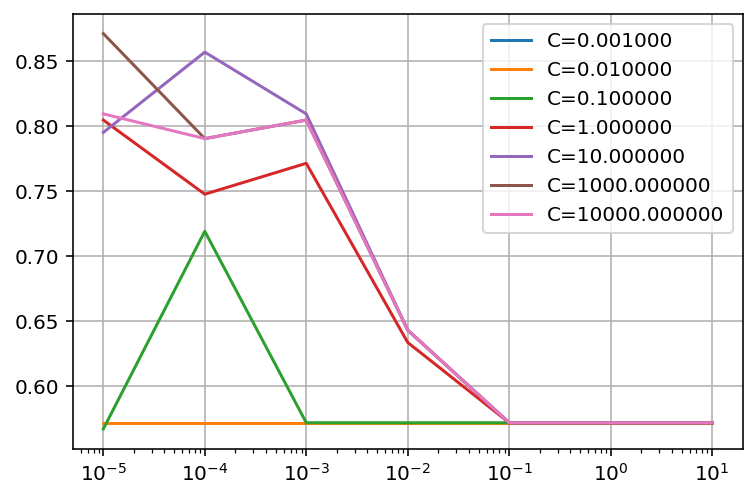

In [19]:
plt.figure()
for iC, C in enumerate(results_rbf.index):
    plt.plot(v_g, results_rbf.loc[C].values, label='C={0:f}'.format(C))
plt.xscale('log')
plt.grid()
_=plt.legend()

#### Discussion

- What are the best values of $C$ and $\gamma$ that yield the better performance in crossvalidation?

- Do you think it worths exploring larger or smaller values for $C$ and/or $\gamma$?

#### your answer

1. The best values for C and Gamma are for C = 1000 and gamma = 10^-5. 
2. After seeing the results, it seems that is worth to allow having some error, ie, allowing C to be large, as we get good results for small gammas and large values of C (C>10).
It could be interesting to search for smaller gammas as they seem to grant better results

The GridSearchCV object has an attribute that facilitates the identification of the best set of hyperparameters (`best_params_`) and also methods to consume the model trained with these best hyperparameters: `score()` and `predict()`.
Print the accuracy in the test set achieved by the SVC with RBF kernel and hyperparameters found by GridSearchCV

In [20]:
best_c = grid_rbf_svc.best_params_["C"]; print(best_c)
best_gamma = grid_rbf_svc.best_params_["gamma"]; print(best_gamma)

Acc_train = print(grid_rbf_svc.score(X_train, y_train)); print(Acc_train)
Acc_test = print(grid_rbf_svc.score(X_test, y_test)); print(Acc_test)

#print(grid_rbf_svc.predict(X_test))


1000.0
1e-05
0.9666666666666667
None
0.9171428571428571
None


#### Discussion

- What kernel gives the best performance in the test set, after tuning the hyperparameters using crossvalidation?



#### your answer

We can see that RBF gives 91.7% of acc, taking into account that the linear kernel gives around 92%, which almost the same, and the fact that the model with a linear kernel takes 4 minutes and the RBF takes less than a second, We like more using the RBF 

## 2.2.- Polynomial kernel

The polynomial kernel introduces a new hyperparameter in the model, the degree of the polynomial $d$. We will consider the following range of values: 
$$
d \in [2,3,4,5,6,7,8,9,10]
$$

Therefore our crossvalidation grid search needs to allocate this new range. 

In the next cell implement code that:
- Defines `v_d`, an array with the range of values for $d$
- Defines `param_poly_svc`, a dictionary with the ranges of $d$ and $C$ for the SVM
- Creates `grid_poly_svc`, a `GridSearchCV` object with an SVC as estimator and  `param_poly_svc` as parameter dictionary
- Train `grid_poly_svc` with `X_train` and `y_train`

In [21]:
from sklearn.model_selection import GridSearchCV

v_d = [2,3,4,5,6,7,8,9,10]
param_poly_svc = {"C": v_C, "degree": v_d,}
grid_poly_svc = GridSearchCV(estimator= SVC(kernel = "poly"), param_grid=param_poly_svc, cv=5, refit=True)
grid_poly_svc.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 1000.0, 10000.0],
                         'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

Now we need to retrieve useful information from attribute `cv_results_`, in particular:
- store in `C_values_poly` the values of parameter $C$ used in each node of the grid
- store in `d_values` the values of parameter $d$ used in each node of the grid
- store in `Acc_poly` the average validation score obtained in each node of the grid


In [22]:
C_values_poly = grid_poly_svc.cv_results_["param_C"].data ; print(C_values_poly)
d_values = grid_poly_svc.cv_results_["param_degree"].data; print(d_values)

Acc_poly =  grid_poly_svc.cv_results_["mean_test_score"]; print(Acc_poly)

grid_poly_svc.cv_results_

[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 1 1 1 1 1 1
 1 1 1 10 10 10 10 10 10 10 10 10 1000.0 1000.0 1000.0 1000.0 1000.0
 1000.0 1000.0 1000.0 1000.0 10000.0 10000.0 10000.0 10000.0 10000.0
 10000.0 10000.0 10000.0 10000.0]
[2 3 4 5 6 7 8 9 10 2 3 4 5 6 7 8 9 10 2 3 4 5 6 7 8 9 10 2 3 4 5 6 7 8 9
 10 2 3 4 5 6 7 8 9 10 2 3 4 5 6 7 8 9 10 2 3 4 5 6 7 8 9 10]
[0.57142857 0.57142857 0.57142857 0.57142857 0.57142857 0.57142857
 0.56190476 0.57142857 0.57619048 0.57142857 0.57142857 0.56190476
 0.56190476 0.62857143 0.58571429 0.58571429 0.66666667 0.64761905
 0.72857143 0.76666667 0.75238095 0.74285714 0.73809524 0.73333333
 0.73809524 0.74761905 0.74761905 0.82857143 0.84285714 0.82380952
 0.80952381 0.7952381  0.8047619  0.8047619  0.8047619  0.8
 0.84285714 0.84285714 0.83809524 0.83809524 0.82380952 0.82380952
 0.80952381 0.8        0.78095238 0.81428571 0.73333333 0.72857143
 0.72380952 0.

{'mean_fit_time': array([0.00263119, 0.00604749, 0.00576239, 0.00365272, 0.00315342,
        0.00311551, 0.        , 0.00312428, 0.00623999, 0.00244102,
        0.00386229, 0.00629878, 0.00313358, 0.007759  , 0.00337396,
        0.00443568, 0.00312347, 0.00475507, 0.00662503, 0.00312757,
        0.00625548, 0.        , 0.00319395, 0.        , 0.        ,
        0.0062479 , 0.00334911, 0.00626016, 0.        , 0.        ,
        0.00023975, 0.00315409, 0.00447898, 0.00312495, 0.00624785,
        0.00271883, 0.00347586, 0.00638256, 0.00333519, 0.00628138,
        0.00718865, 0.00486093, 0.0025033 , 0.00691657, 0.00758433,
        0.03447647, 0.0293365 , 0.0247993 , 0.0218647 , 0.01295319,
        0.01648974, 0.01998672, 0.02348642, 0.03166652, 0.1262886 ,
        0.09144049, 0.06323276, 0.05102563, 0.05209618, 0.06017265,
        0.05684915, 0.06351919, 0.06217742]),
 'std_fit_time': array([0.00160902, 0.00253887, 0.00575316, 0.00608755, 0.00630684,
        0.00623102, 0.        , 0.006

In [23]:
# do not edit this cell, just run it
results_poly = (pd.DataFrame(np.vstack((C_values_poly, 
                                 d_values,
                                 Acc_poly)).T,
                      columns=['C','d','Acc'])).pivot(columns='d', index='C')
results_poly

Acc                                                    \
d                2         3         4         5         6         7    
C                                                                       
0.001      0.571429  0.571429  0.571429  0.571429  0.571429  0.571429   
0.010      0.571429  0.571429  0.561905  0.561905  0.628571  0.585714   
0.100      0.728571  0.766667  0.752381  0.742857  0.738095  0.733333   
1.000      0.828571  0.842857   0.82381  0.809524  0.795238  0.804762   
10.000     0.842857  0.842857  0.838095  0.838095   0.82381   0.82381   
1000.000   0.814286  0.733333  0.728571   0.72381  0.733333  0.742857   
10000.000  0.814286   0.77619  0.771429  0.733333  0.714286   0.72381   

                                         
d                8         9         10  
C                                        
0.001      0.561905  0.571429   0.57619  
0.010      0.585714  0.666667  0.647619  
0.100      0.738095  0.747619  0.747619  
1.000      0.804762  0.804762       0.8  
10.000     0.809524       0.8  0.780952  
1000.000   0.719048  0.738095  0.738095  
10000.000  0.714286       0.7  0.742857

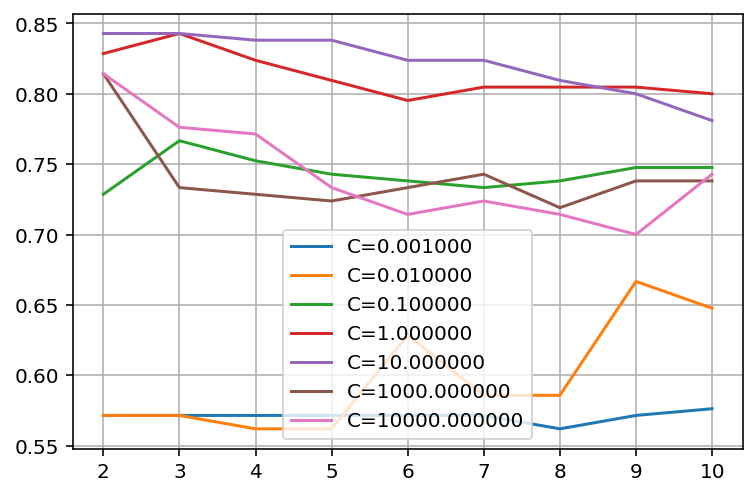

In [24]:
plt.figure()
for C in results_poly.index:
    plt.plot(v_d, results_poly.loc[C].values, label='C={0:f}'.format(C))

plt.grid()
_=plt.legend()

#### Discussion

- What are the best values of $C$ and $d$ that yield the better performance in crossvalidation?

- Do you think it worths exploring larger or smaller values for $C$ and/or $d$?

- What is more critial for the performance of the classifier, the selection of $C$ or the degree?

- What is the performance of the SVM with polynomial kernel and parameters tuned using crossvalidation in the test set? How does it compare with the other two kernels?

#### your answer

1. C = 10 as in most of the previous cases and d = 2

2. For this case, it´s worth any value of C larger than 0.1, but it has to be bounded. 
With respect to d, large values seem to achieve a lower performance so it does not make much sense to explore for bigger values of d.

3. It is more critical the selection of C as for d, the accuracy changes a bit but for the case of C it shifts the accuracy up and down making the most interesting parameter.

4. As it happens most of the times, accuracy using the polynomial kernel (85%) is worse than RBF, it takes little time but loses accuracy

# 3.- Scaling

The last step in the development of the model involves a data preprocessing with a Standard Scaler. Since the scaling can affect the performance achieved by the SVC endowed by any of the three kernels, we will carry out a single validation procedure that searches the best option within the three kernels.

For this purpose, in the next cell write code that:
- defines `pipe_svc`, a `Pipeline` with a first stage that is an `StandardScaler` followed by a SVC
- defines `param_svc` as the object needed to pass the ranges of hyperparameters to the SVC inside the Pipeline. Check the documentation of GridSearchCV and Pipeline. In essence, `param_svc` needs to be a list of three dictionaries, each dictionary with the ranges of parameters needed by each kernel.
- Create `grid_sc_svc`, the `GridSearchCV` object with `pipe_svc` as estimator and `param_svc` as parameter dictionary
- Train `grid_sc_svc` with `X_train` and `y_train`

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_svc = Pipeline([('scaler', StandardScaler()), 
                 ('svc', SVC())]) 

param_svc = [
            {"svc__kernel": ["linear"], "svc__C": v_C}, 
            {"svc__kernel": ["rbf"], "svc__C": v_C, "svc__gamma": v_g,},
            {"svc__kernel": ["poly"], "svc__C": v_C, "svc__degree": v_d}
               ]
grid_sc_svc = GridSearchCV(estimator= pipe_svc, param_grid=param_svc, cv=5, refit=True)
grid_sc_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid=[{'svc__C': [0.001, 0.01, 0.1, 1, 10, 1000.0, 10000.0],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.001, 0.01, 0.1, 1, 10, 1000.0, 10000.0],
                          'svc__gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                         10],
                          'svc__kernel': ['rbf']},
                         {'svc__C': [0.001, 0.01, 0.1, 1, 10, 1000.0, 10000.0],
                          'svc__degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'svc__kernel': ['poly']}])

In [26]:
grid_sc_svc.best_params_

{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

#### Discussion

- What is the configuration of the best classifier found by crossvalidation?

- What is the impact of the scaling in the performance of the classifier?


1. Configuration for rbf kernel is C = 1 and Gamma = 0.1

2. Thanks to the use of scaling, RBF increses its results. When features are on different scales, the kernel might give more importance to the features with larger scales, potentially leading to worse results, so by scaling we make sure that all features contribute equally to the kernel calculation